In [1]:
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Layer
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from kerashypetune import KerasGridSearch
from keras.layers import concatenate
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dropout, Dense, LSTM, Concatenate, Flatten, Conv1D



from numpy import array
from numpy import dstack
from numpy import unique
from pandas import read_csv
from matplotlib import pyplot

In [10]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
    # get row indexes for the subject id
    ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
    # return the selected samples
    return X[ix, :, :], y[ix]

# convert a series of windows to a 1D list
def to_series(windows):
    series = list()
    for window in windows:
        # remove the overlap from the window
        half = int(len(window) / 2) - 1
        for value in window[-half:]:
            series.append(value)
    return series

# group data by activity
def data_by_activity(X, y, activities):
    # group windows by activity
    return {a:X[y[:,0]==a, :, :] for a in activities}

# plot histograms for each activity for a subject
def plot_activity_histograms(X, y):
    # get a list of unique activities for the subject
    activity_ids = unique(y[:,0])
    # group windows by activity
    grouped = data_by_activity(X, y, activity_ids)
    # plot per activity, histograms for each axis
    pyplot.figure()
    xaxis = None
    for k in range(len(activity_ids)):
        act_id = activity_ids[k]
        # total acceleration
        for i in range(3):
            ax = pyplot.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
            ax.set_xlim(-1,1)
            if k == 0:
                xaxis = ax
            pyplot.hist(to_series(grouped[act_id][:,:,i]), bins=100)
            pyplot.title('activity '+str(act_id), y=0, loc='left')
    pyplot.show()

In [11]:
# load all train
X_train, y_train = load_dataset('train', '/Users/pranavtushar/Documents/time-series/HARDataset/')
print(X_train.shape, y_train.shape)

# load all test
X_test, y_test = load_dataset('test', '/Users/pranavtushar/Documents/time-series/HARDataset/')
print(X_test.shape, y_test.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


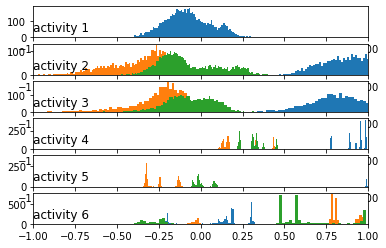

In [12]:
sub_map = load_file('/Users/pranavtushar/Documents/time-series/HARDataset/train/subject_train.txt')
train_subjects = unique(sub_map)
sub_map1 = load_file('/Users/pranavtushar/Documents/time-series/HARDataset/test/subject_test.txt')
test_subjects = unique(sub_map1)
# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(X_train, y_train, sub_map, sub_id)
sub_id1 = test_subjects[0]
subX1, suby1 = data_for_subject(X_test, y_test, sub_map, sub_id1)
# plot data for subject
plot_activity_histograms(subX, suby)
# plot_activity_histograms(subX1, suby1)

In [13]:
class Sine(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        """
        Sine activation function with learnable w0 scaling support.
        Args:
            w0: w0 in the activation step `act(x; w0) = sin(w0 * x)`
        """
        super(Sine, self).__init__(**kwargs)
        #self.w0 = w0
    
    def build(self, input_shape):
        self.w0 = self.add_weight(shape=(1,),
                             initializer='ones',
                             trainable=True)

    def call(self, inputs):
        return tf.sin(self.w0 * inputs)
    
    def get_config(self):
        config = {'w0': self.w0}
        base_config = super(Sine, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [14]:
class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p #if i = 0
        sin_trans = K.sin(K.dot(x, self.W) + self.P) # Frequecy and phase shift of sine function, learnable parameters. if 1 <= i <= k
        
        return K.concatenate([sin_trans, original], -1)

In [15]:
class NeuralNetwork:

    def __init__(self, 
                param={
                    'unit': 32,
                    't2v_dim': 64,
                    'lr': 1e-4, 
                    'act': 'relu', 
                    'epochs': 5,
                    'batch_size': 16
                }, dim=50):
        self.param = param
        self.dim = dim

    def set_LSTM(self):  
        # Model with 1 LSTM, 1 Hidden Dense, and 1 output Dense layer 

        inp = layers.Input(shape=(self.dim, 9))
        x = LSTM(self.param['unit'], activation=self.param['act'])(inp)
        x = Dense(16, activation=self.param['act'])(x)
        x = Dropout(0.2)(x)
        x = Dense(1)(x)
        m = Model(inp, x)
        m.compile(loss='categorical_crossentropy', optimizer='adam')
        m.summary()
        self.model = m
    
    def set_conv1D(self):
        # Model with 1 Conv1D, 1 Hidden Dense, and 1 output Dense layer 
        inp = layers.Input(shape=(self.dim, 9))
        x = Conv1D(self.param['t2v_dim'], kernel_size=6, activation='relu')(inp)
        x = Dense(32, activation=self.param['act'])(x)
        x = Dropout(0.2)(x)
        x = Dense(1)(x)
        m = Model(inp, x)
        m.compile(loss='categorical_crossentropy', optimizer='adam')
        m.summary()
        self.model = m

    def set_time2vec(self):
        # Model with 1 Time2Vec embedding layer, 1LSTM, 1 Hidden Dense, and 1 output Dense layer 
        inp = layers.Input(shape=(self.dim, 9))
        x = T2V(self.param['t2v_dim'])(inp)
        x = LSTM(self.param['unit'], activation=self.param['act'])(x)
        x = Dense(32, activation=self.param['act'])(x)
        x = Dropout(0.2)(x)
        x = Dense(1)(x)
        m = Model(inp, x)
        m.compile(loss='categorical_crossentropy', optimizer='adam')
        m.summary()
        self.model = m
    
    def set_freqLSTM(self):  
        # Model with 1 freq LSTM, 1 freq Hidden Dense, and 1 output Dense layer 
        inp = layers.Input(shape=(self.dim, 9))
        x = Sine()(LSTM(self.param['unit'])(inp))
        x = Sine()(Dense(32)(x))
        x = Dropout(0.2)(x)
        x = Dense(1)(x)
        m = Model(inp, x)
        m.compile(loss='categorical_crossentropy', optimizer='adam')
        m.summary()
        self.model = m

    def set_neuraltime2vec(self):
        # Model with 2 branches, and 1 output Dense layer
        # Branch 1: [1LSTM, 1 Hidden Dense]
        # Branch 2: [1 freq LSTM, 1 freq Hidden Dense]

        inp = layers.Input(shape=(self.dim, 9))

        # Time domain
        x1 = LSTM(self.param['unit'], activation=self.param['act'])(inp)
        x1 = Dense(16)(x1)

        # Freq domain
        x2 = Sine()(LSTM(32)(inp))
        x2 = Sine()(Dense(16)(x2))

        # Fusion
        x = Concatenate()([x1, x2])
        x = Dropout(0.2)(x)
        x = Dense(1)(x)
        
        m = Model(inp, x)
        m.compile(loss='categorical_crossentropy', optimizer='adam')
        m.summary()
        self.model = m
    
    def train(self, X_train, y_train, epochs=20):

        self.history = self.model.fit(X_train, y_train, epochs=5, validation_split=0.2, shuffle=False, batch_size=self.param["batch_size"], verbose=1)
    
    def plot_training(self):

        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def evaluate(self, X_test, y_test):

        self.model.evaluate(X_test, y_test)

    def plot_predictions(self, y_test, y_hat, item="HAR Data"):

        plt.plot(y_test, label=f"Actual {item}", color='green')
        plt.plot(y_hat, label=f"Predicted {item}", color='red')
        
        plt.title(f'{item} prediction')
        plt.xlabel('Time [days]')
        plt.ylabel(f'{item}')
        plt.legend(loc='best')
        plt.show()

In [16]:
lstm_instance = NeuralNetwork(dim=128)
lstm_instance.set_LSTM()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 9)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 5,921
Trainable params: 5,921
Non-trainable params: 0
_________________________________________________________________


In [17]:
lstm_instance.train(X_train, y_train)

Epoch 1/5
368/368 [==============================] - 9s 24ms/step - loss: nan - val_loss: nan
Epoch 2/5
368/368 [==============================] - 8s 23ms/step - loss: nan - val_loss: nan
Epoch 3/5
368/368 [==============================] - 9s 24ms/step - loss: nan - val_loss: nan
Epoch 4/5
368/368 [==============================] - 9s 24ms/step - loss: nan - val_loss: nan
Epoch 5/5
368/368 [==============================] - 9s 24ms/step - loss: nan - val_loss: nan


In [18]:
y_hat = lstm_instance.model.predict(X_test)

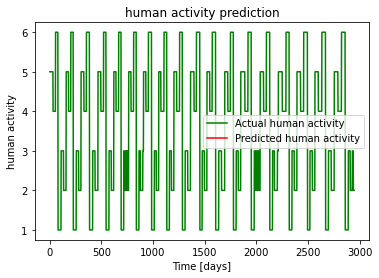

In [19]:
lstm_instance.plot_predictions(y_test, y_hat, item= "human activity")

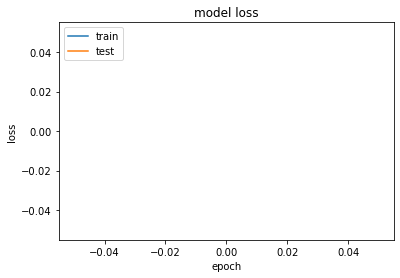

In [20]:
lstm_instance.plot_training()

In [21]:
lstm_instance.evaluate(X_test, y_test)

93/93 [==============================] - 1s 6ms/step - loss: nan


In [22]:
freqlstm_instance = NeuralNetwork(dim=128)
freqlstm_instance.set_freqLSTM()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 9)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                5376      
_________________________________________________________________
sine (Sine)                  (None, 32)                1         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
sine_1 (Sine)                (None, 32)                1         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33  

In [23]:
freqlstm_instance.train(X_train, y_train)
y_hat = freqlstm_instance.model.predict(X_test)

Epoch 1/5
368/368 [==============================] - 9s 24ms/step - loss: 4.2394e-07 - val_loss: 4.3923e-07
Epoch 2/5
368/368 [==============================] - 8s 23ms/step - loss: 4.2394e-07 - val_loss: 4.3923e-07
Epoch 3/5
368/368 [==============================] - 8s 23ms/step - loss: 4.2394e-07 - val_loss: 4.3923e-07
Epoch 4/5
368/368 [==============================] - 8s 23ms/step - loss: 4.2394e-07 - val_loss: 4.3923e-07
Epoch 5/5
368/368 [==============================] - 8s 23ms/step - loss: 4.2394e-07 - val_loss: 4.3923e-07


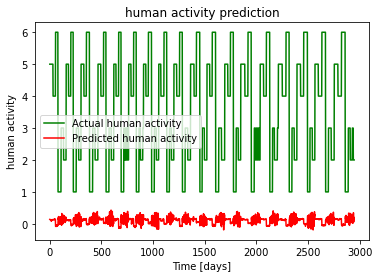

In [24]:
freqlstm_instance.plot_predictions(y_test, y_hat, item= "human activity")

In [25]:
freqlstm_instance.evaluate(X_test, y_test)

93/93 [==============================] - 1s 6ms/step - loss: 4.2652e-07


In [26]:
t2v_lstm = NeuralNetwork(dim = 128)
t2v_lstm.set_time2vec()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 9)]          0         
_________________________________________________________________
t2v (T2V)                    (None, 128, 73)           9024      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                13568     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 23,681
Trainable params: 23,681
Non-trainable params: 0
_______________________________________________________

In [27]:
t2v_lstm.train(X_train, y_train)
y_hat = t2v_lstm.model.predict(X_test)

Epoch 1/5
368/368 [==============================] - 11s 27ms/step - loss: 4.2394e-07 - val_loss: 4.3923e-07
Epoch 2/5
368/368 [==============================] - 10s 27ms/step - loss: 4.2394e-07 - val_loss: 4.3923e-07
Epoch 3/5
368/368 [==============================] - 10s 27ms/step - loss: 4.2394e-07 - val_loss: 4.3923e-07
Epoch 4/5
368/368 [==============================] - 10s 26ms/step - loss: 4.2394e-07 - val_loss: 4.3923e-07
Epoch 5/5
368/368 [==============================] - 10s 27ms/step - loss: 4.2394e-07 - val_loss: 4.3923e-07


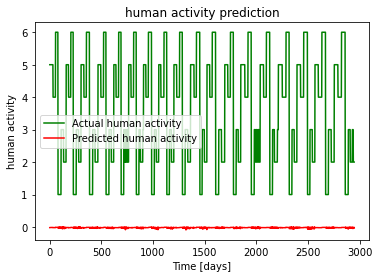

In [28]:
t2v_lstm.plot_predictions(y_test, y_hat, item= "human activity")

### Neural Time2Vec (Ours) prediction

In [29]:
neural_time2vec = NeuralNetwork(dim = 128)
neural_time2vec.set_neuraltime2vec()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 9)]     0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 32)           5376        input_5[0][0]                    
__________________________________________________________________________________________________
sine_2 (Sine)                   (None, 32)           1           lstm_5[0][0]                     
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 32)           5376        input_5[0][0]                    
____________________________________________________________________________________________

In [30]:
neural_time2vec.train(X_train, y_train)
y_hat = neural_time2vec.model.predict(X_test)

Epoch 1/5
368/368 [==============================] - 12s 30ms/step - loss: 4.2394e-07 - val_loss: 4.3923e-07
Epoch 2/5
368/368 [==============================] - 11s 30ms/step - loss: 4.2394e-07 - val_loss: 4.3923e-07
Epoch 3/5
368/368 [==============================] - 11s 30ms/step - loss: 4.2394e-07 - val_loss: 4.3923e-07
Epoch 4/5
368/368 [==============================] - 11s 30ms/step - loss: 4.2394e-07 - val_loss: 4.3923e-07
Epoch 5/5
368/368 [==============================] - 11s 30ms/step - loss: 4.2394e-07 - val_loss: 4.3923e-07


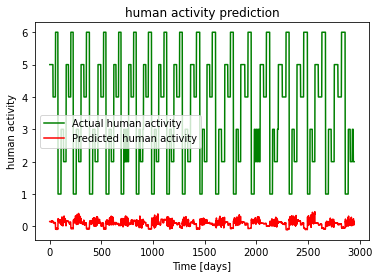

In [31]:
neural_time2vec.plot_predictions(y_test, y_hat, item= "human activity")

In [32]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_hat, normalize=False)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets